# Neural Networks - Other parameters


* [1. The solver](#solver)
* [2. The learning rate](#lr)
* [3. The learning rate initialization](#lr_init)
* [4. The batch size](#batch)
* [5. Other parameters](#other)



* [Exercise 1. The combination of different ranges in scaling and the use of activation functions](#activation)
* [Exercise 2 - The effects of changing the learning rate initialization](#activation)


In the previous week, we saw that we could change the structure of our network using the parameter `hidden_layer_sizes`, and the number of iterations using `max_iter`. In this notebook we are going to check some other important parameters that can influence the performance of a neural network.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import numpy as np

#set random seed
np.random.seed(369)

In [2]:
def avg_score(model):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    for train_index, test_index in skf.split(X,y):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        min_max = MinMaxScaler().fit(X_train)
        # Transform your train data by applying the scale obtained in the previous command
        scaled_X_train = min_max.transform(X_train)
        # Transform your validation data by applying the scale obtained in the first command
        scaled_X_val = min_max.transform(X_val)
        
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(scaled_X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(scaled_X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(scaled_X_val,y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)

def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    #scale = scale
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1
    return df

In [3]:
diabetes = pd.read_csv(r'./Datasets/diabetes.csv')
X = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,-1]

In [4]:
model = MLPClassifier(random_state=42)
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['Raw'])
show_results(df, model)

,Time,Train,Test,Iterations
Raw,0.188+/-0.01,0.792+/-0.0,0.77+/-0.04,200.0+/-0.0


<hr>
<a class="anchor" id="solver">
    
### 1. The solver

    
</a>

#### `default = 'adam'`
For more information check this paper: <br>   

http://www.robotics.stanford.edu/~ang/papers/icml11-OptimizationForDeepLearning.pdf <br>



__`Step 1`__ Create an instance of MLPClassifier, define the solver as __lgfgs__ and name it as __model_lbfgs__

In [5]:
model_lbfgs = MLPClassifier(solver = 'lbfgs', random_state=42)

__When to use__ <br>
- L-BFGS is a good option for low dimensional models and for sparse data. <br> Link to L-BFGS paper: http://users.iems.northwestern.edu/~nocedal/PDFfiles/limited-memory.pdf

__`Step 2`__ Create an instance of MLPClassifier, define the solver as __sgd__ and name ir as __model_sgd__

In [6]:
model_sgd = MLPClassifier(solver = 'sgd', random_state=42)

__When to use__
- If generalization is more important than time processing - Some recent papers observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance.
(https://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf)

__Notes__
- While Gradient Descent use the whole training data to do a single update, in SGD a random data point of the training data to update the parameters - SGD is faster than GD.
- It uses a common learning rate for all parameters, contrarialy to what happen in Adam.

__`Step 3`__ Create an instance of MLPClassifier, define the solver as __adam__ and name it as __model_adam__

In [7]:
model_adam = MLPClassifier(solver = 'adam', random_state=42)

__When to use__ <br>
- It achieves good results fast - good for complex models, if processing time is an issue. <br>
Link to paper: https://arxiv.org/pdf/1412.6980.pdf

__Notes__ <br>
- It computes individual adaptive learning rates for different parameters
- Adam combines the advantages of RMSProp and AdaGrad <br>
(For more about Adam, check this: https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c)
- Recent research papers have noted that it can fail to converge to an optimal solution under specific settings.
(The paper https://arxiv.org/pdf/1712.07628.pdf demonstrates that adaptive optimization techniques such as Adam generalize poorly compared to SGD)



__`Step 4`__ Check the mean accuracy of each model by calling the function _show_results_ and pass as arguments the dataset and the three models.

In [8]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['lbfgs','sgd','adam'])
show_results(df, model_lbfgs, model_sgd, model_adam)

,Time,Train,Test,Iterations
lbfgs,0.276+/-0.03,0.852+/-0.01,0.749+/-0.05,200.0+/-0.0
sgd,0.175+/-0.0,0.651+/-0.0,0.651+/-0.0,200.0+/-0.0
adam,0.183+/-0.0,0.792+/-0.0,0.77+/-0.04,200.0+/-0.0


In sklearn, the number of iterations for __sgd__ and __adam__ correspond to the number of epochs (an epoch consists of one full cycle through the training data.), while for __lbfgs__ it corresponds to one gradient update.

<hr>
<a class="anchor" id="lr">

### 2. The learning rate (Only for sgd)
</a>

#### `default = 'constant'`

__`Step 5`__ Create an instance of MLPClassifier, define the solver as __sgd__, the learning_rate as __constant__ and name it as __model_constant__

In [9]:
model_constant = MLPClassifier(solver = 'sgd', learning_rate = 'constant', random_state=42)

__Definition__<br>
If the learning rate is constant, as the name says, the learning rate will always remain equal to the initial learning rate.

__`Step 6`__ Create an instance of MLPClassifier, define the solver as __sgd__, the learning_rate as __invscaling__ and name it as __model_invscaling__

In [10]:
model_invscaling = MLPClassifier(solver = 'sgd', learning_rate = 'invscaling', random_state=42)

__Definition__<br>
If the learning rate is invscaling, it gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. <br><br>

The 'invscaling' learning rate in sklearn is calculated using the following equation:

$$
\text{effective\_learning\_rate} = \frac{\text{learning\_rate\_init}}{t^{\text{power\_t}}}
$$

Where:
- `learning_rate_init` is the initial learning rate.
- `t` is the current time step.
- `power_t` is the power for inverse scaling and another parameter that you can change.

__`Step 7`__ Create an instance of MLPClassifier, define the solver as __sgd__, the learning_rate as __adaptive__ and name it as __model_adaptive__

In [11]:
model_adaptive = MLPClassifier(solver = 'sgd', learning_rate = 'adaptive', random_state=42)

__Definition__ <br>
If the learning rate is adaptive, then it keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. <br><br>
Each time two consecutive epochs fail to decrease training loss by at least __tol__ (another parameter that you can change), or fail to increase validation score by at least __tol__ if __early_stopping__ (another parameter that you can change) is on, the current learning rate is divided by 5.

__`Step 8`__ Check the mean accuracy of each model by calling the function _show_results_ and pass as arguments the dataset and the three models.

In [12]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['constant','invscaling','adaptive'])
show_results(df, model_constant, model_invscaling, model_adaptive)

,Time,Train,Test,Iterations
constant,0.179+/-0.01,0.651+/-0.0,0.651+/-0.0,200.0+/-0.0
invscaling,0.017+/-0.0,0.652+/-0.0,0.652+/-0.01,17.8+/-0.4
adaptive,0.179+/-0.0,0.651+/-0.0,0.651+/-0.0,200.0+/-0.0


<hr>
<a class="anchor" id="lr_init">

### 3. The learning rate initialization (only for sgd and adam)
    
</a>

#### `default = '0.001'`

The learning rate is one of the most important hyper-parameters to tune for training deep neural networks:

__In theory, for the generality of the cases:__ 

__Small LR__
- If the learning rate is small, then training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny - a smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train.
- A learning rate that is too small may never converge or may get stuck on a suboptimal solution.

__Big LR__
- If the learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse - a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights.


The training should start from a relatively large learning rate because, in the beginning, random weights are far from optimal, and then the learning rate can decrease during training to allow more fine-grained weight updates.

<img src="lr.png" alt="Drawing" style="width: 600px;"/>

__`Step 9`__ Create an instance of MLPClassifier, define the solver as __sgd__, the learning_rate_init as __0.5__ and name it as __model_lr_big__

In [13]:
model_lr_big = MLPClassifier(learning_rate_init = 0.5, max_iter = 1000, random_state=42)

__`Step 10`__ Create an instance of MLPClassifier, define the solver as __sgd__, the learning_rate_init as __0.001__ and name it as __model_lr_medium__

In [14]:
model_lr_medium = MLPClassifier(learning_rate_init = 0.001, max_iter = 1000, random_state=42)

__`Step 11`__ Create an instance of MLPClassifier, define the solver as __sgd__, the learning_rate_init as __0.000001__ and name it as __model_lr_small__

In [15]:
model_lr_small = MLPClassifier(learning_rate_init = 0.000001, max_iter = 1000, random_state=42)

__`Step 12`__ Check the mean accuracy of each model by calling the function _show_results_ and pass as arguments the dataset and the three models.

In [16]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['big','medium','small'])
show_results(df, model_lr_big, model_lr_medium, model_lr_small)

,Time,Train,Test,Iterations
big,0.033+/-0.01,0.734+/-0.05,0.736+/-0.07,33.7+/-7.9
medium,0.66+/-0.22,0.81+/-0.01,0.766+/-0.05,706.7+/-231.5
small,0.012+/-0.0,0.653+/-0.0,0.655+/-0.02,12.0+/-0.0


<hr>
<a class="anchor" id="batch">

### 4. The batch size
</a>

#### `default = 'auto' (min(200, n_samples))`

The batch size can affect significantly the performance and the speed of your training. What happens when you put a batch through your network is that you average the gradients. <br>

__In theory, for the generality of the cases:__ 

__Small batch size__
- The lower the batch size, the higher the probability of your estimate being less accurate, since the networks weights can "jump" around if your data is noisy, and it might be unable to learn, or it converges very slow. Besides that, the computation time is going to increase.
- It can be useful in some cases to escape local minima.
- Sometimes, and depending on your computational resources, this is the only option.

__Big batch size__
- If your batch size is big enough, this will provide a stable enough estimate of what the gradient of the full dataset would be, since you will have fewer gradient updates per epoch.
- In the same logic, it is desired to speed up computation, due to a lower quantity of updates.

__`Step 13`__ Create an instance of MLPClassifier, define the batch_size as __1__ and name it as __model_batch1__

In [17]:
model_batch1 = MLPClassifier(batch_size = 1, random_state=42)

__`Step 14`__ Create an instance of MLPClassifier, define the batch_size as __50__ and name it as __model_batch50__

In [18]:
model_batch50 = MLPClassifier(batch_size = 50, random_state=42)

__`Step 15`__ Create an instance of MLPClassifier, define the batch_size equal to the number of samples we have in the entire dataset and name it as __model_batchlen__

In [19]:
model_batchlen = MLPClassifier(batch_size = len(df), random_state=42)

__`Step 16`__ Check the mean accuracy of each model by calling the function _show_results_ and pass as arguments the dataset and the three models.

In [20]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['batch 1','batch 50','Gradient Descent'])
show_results(df, model_batch1, model_batch50, model_batchlen)

,Time,Train,Test,Iterations
batch 1,5.051+/-1.88,0.814+/-0.01,0.772+/-0.05,106.3+/-39.5
batch 50,0.268+/-0.02,0.796+/-0.01,0.768+/-0.04,195.9+/-12.3
Gradient Descent,1.341+/-0.5,0.802+/-0.01,0.758+/-0.05,85.0+/-31.2


In [25]:
#using the holdout method for the next cell
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.3, random_state = 150, shuffle = True, stratify = y)

min_max = MinMaxScaler().fit(X_train)
new_X_train = min_max.transform(X_train)
new_X_val = min_max.transform(X_val)

<Axes: title={'center': 'batch537 | Final Loss: 0.65'}>

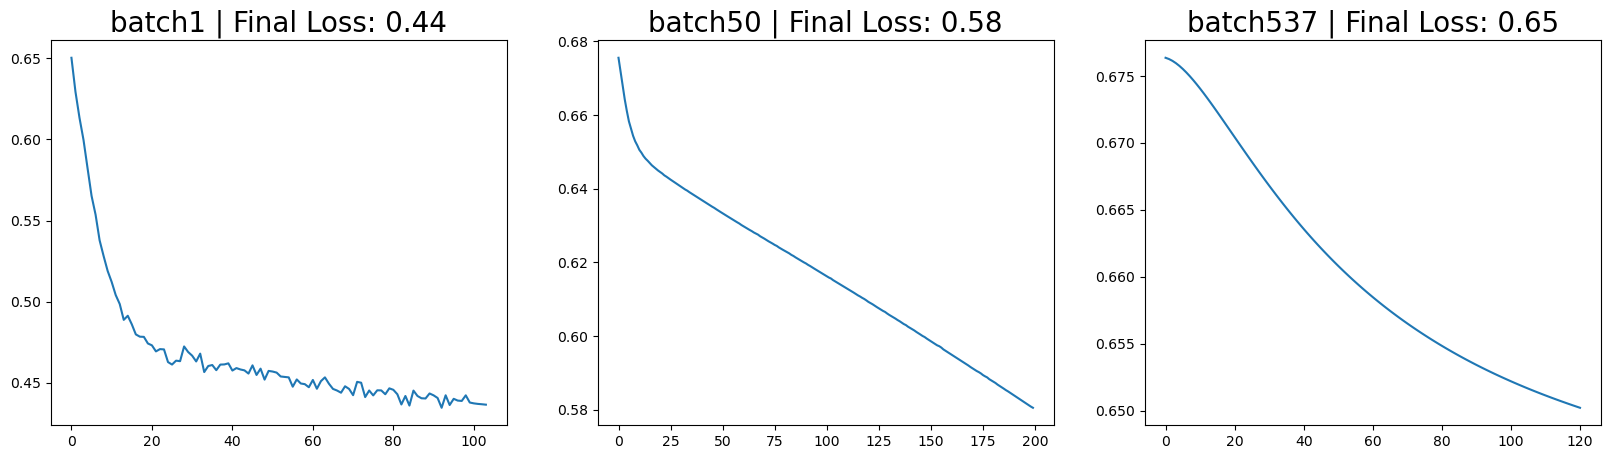

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

model_batch1 = MLPClassifier(solver = 'sgd', batch_size = 1, random_state = 42).fit(new_X_train, y_train)
model_batch50 = MLPClassifier(solver = 'sgd', batch_size = 50, random_state = 42).fit(new_X_train, y_train)
model_batchlen = MLPClassifier(solver = 'sgd', batch_size = len(X_train), random_state = 42).fit(new_X_train, y_train)

losses_batch1 = model_batch1.loss_curve_
iterations_batch1 = range(model_batch1.n_iter_)
losses_batch50 = model_batch50.loss_curve_
iterations_batch50 = range(model_batch50.n_iter_)
losses_batchlen = model_batchlen.loss_curve_
iterations_batchlen = range(model_batchlen.n_iter_)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('batch1 | Final Loss: ' + str(round(model_batch1.loss_,2)), fontsize=20)
sns.lineplot(x = iterations_batch1, y = losses_batch1)
plt.subplot(132)
plt.title('batch50 | Final Loss: ' + str(round(model_batch50.loss_,2)),fontsize=20)
sns.lineplot(x = iterations_batch50, y = losses_batch50)
plt.subplot(133)
plt.title('batch' + str(len(X_train)) + ' | Final Loss: ' + str(round(model_batchlen.loss_,2)),fontsize=20)
sns.lineplot(x = iterations_batchlen, y = losses_batchlen)

<hr>
<a class="anchor" id="other">

### 5. Other parameters
</a>

|Parameter| Definition | LBFGS | SGD | ADAM |
|---|---|---|---|---|
|alpha| L2 penalty (regularization term) parameter | yes | yes | yes |
| power_t | The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. | no | yes | no |
| shuffle | Whether to shuffle samples in each iteration. | no | yes | yes |
| tol | Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops. | yes | yes | yes |
| warm_start | When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. | yes | yes | yes |
| momentum | Momentum for gradient descent update. Should be between 0 and 1. | no | yes | no |
| nesterovs_momentum | Whether to use Nesterov’s momentum.| no | yes | no |
| early stopping | Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting.  | no | yes | yes |
| validation_fraction | The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True | no | yes | yes|
| beta1 | Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). | no | no | yes |
| beta2 | Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1).  | no | no | yes |
| epsilon | Value for numerical stability in adam. | no | no | yes |
| n_iter_no_change | Maximum number of epochs to not meet tol improvement. |  no | yes | yes |
| max_fun | Only used when solver=’lbfgs’. Maximum number of loss function calls. The solver iterates until convergence (determined by ‘tol’), number of iterations reaches max_iter, or this number of loss function calls. | yes | no | no |

>><font color='Orange'> __Practice__  </font>

<div class="alert alert-block alert-info">

## Exercise 1 - The combination of different ranges in scaling and the use of activation functions
    
</div>

<a class="anchor" id="activation">
    
### The activation function 
</a>

#### `default = 'relu'`

Check this link for more information regarding the advantages and disadvantages of different activation functions: <br>https://indiantechwarrior.com/7-types-of-neural-network-activation-functions-how-to-choose/

__`Step 1`__ Create an instance of MLPClassifier, define the activation as __relu__, the __hidden_layer_sizes = (8)__ and the __max_iter = 1000__. Name it as __model_relu__.

In [28]:
model_relu = MLPClassifier(activation = 'relu', hidden_layer_sizes=(8), max_iter = 1000, random_state=42)

 - __Advantages:__
     - Computationally efficient - allows the network to converge very quickly.
     - Nonlinear - Although it looks like a linear function, ReLU has a derivative function and allows for backpropagation
 - __Disadvantages:__
     - The dying ReLU problem - When inputs approach zero, or are negative, the gradient of the function becomes zero and the network cannot perform backpropagation and cannot learn.

__`Step 2`__ Create an instance of MLPClassifier, define the activation as __logistic__, the __hidden_layer_sizes = (8)__ and the __max_iter = 1000__. Name it as __model_logistic__.

In [29]:
model_logistic = MLPClassifier(activation = 'logistic', hidden_layer_sizes=(8), max_iter = 1000, random_state=42)

 - __Advantages:__
     - Smooth gradient, preventing “jumps” in output values.
     - Output values bound between 0 and 1, normalizing the output of each neuron.
 - __Disadvantages:__
     - Vanishing gradient—for very high or very low values of X, there is almost no change to the prediction, causing a vanishing gradient problem. This can result in the network refusing to learn further, or have slow convergence.
     - Computationally expensive.

__`Step 3`__ Create an instance of MLPClassifier, define the activation as __tanh__, the __hidden_layer_sizes = (8)__ and the __max_iter = 1000__. Name it as __model_tanh__.

In [31]:
model_tanh = MLPClassifier(activation = 'tanh', hidden_layer_sizes=(8), max_iter = 1000, random_state=42)

 - __Advantages:__
     - Zero centered - making it easier to model inputs that have strongly negative, neutral and strongly positive values. Otherwise like sigmoid function. <br>
 - __Disadvantages:__
     - Like the logistic function

__`Step 4`__ Create a new avg_score function, named as `avg_score2`, but this time include the option of applying also MinMaxScaler in the range [-1,1].  

In [32]:
# the parameter 'scale' in the function avg_score2 is a string that will receive 
# the option 'minmax' (range between 0 and 1) or minmax2 (range between -1 and 1) 
def avg_score2(model, scale): 
    
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    for train_index, test_index in skf.split(X,y):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        if scale == 'minmax':
            #scale your data using MinMaxScaler[-1,1]
            # Create a MinMaxScaler instance that will range between -1 and 1 and fit to your train data
            min_max = MinMaxScaler().fit(X_train)
            # Transform your train data by applying the scale obtained in the previous command
            scaled_X_train = min_max.transform(X_train)
            # Transform your validation data by applying the scale obtained in the first command
            scaled_X_val = min_max.transform(X_val)
        elif scale == 'minmax2':
            min_max = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
            # Transform your train data by applying the scale obtained in the previous command
            scaled_X_train = min_max.transform(X_train)
            # Transform your validation data by applying the scale obtained in the first command
            scaled_X_val = min_max.transform(X_val)
        elif scale == 'robust':
            robust = RobustScaler().fit(X_train)
            # Transform your train data by applying the scale obtained in the previous command
            scaled_X_train = robust.transform(X_train)
            # Transform your validation data by applying the scale obtained in the first command
            scaled_X_val = robust.transform(X_val)
        
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(scaled_X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(scaled_X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(scaled_X_val,y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)


In [33]:
def show_results2(df, scale, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    scale = scale
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score2(arg, scale)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1
    return df

__`Step 5`__Using the function `show_results2`, check what is the average number of iterations needed to find convergence using the activation functions relu, logistic and tanh, using MinMaxScaler in the range [0,1].

In [34]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['relu','logistic','tanh'])
show_results2(df, 'minmax', model_relu, model_logistic, model_tanh)

,Time,Train,Test,Iterations
relu,0.213+/-0.02,0.778+/-0.0,0.767+/-0.04,628.9+/-30.8
logistic,0.292+/-0.01,0.762+/-0.01,0.757+/-0.04,863.6+/-25.9
tanh,0.222+/-0.01,0.778+/-0.01,0.766+/-0.04,645.8+/-24.2


__`Step 6`__Using the function `show_results2`, check what is the average number of iterations needed to find convergence using the activation functions relu, logistic and tanh, using MinMaxScaler in the range [-1,1].

In [35]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['relu','logistic','tanh'])
show_results2(df, 'minmax2', model_relu, model_logistic, model_tanh)

,Time,Train,Test,Iterations
relu,0.083+/-0.01,0.781+/-0.01,0.775+/-0.04,245.0+/-40.3
logistic,0.147+/-0.01,0.776+/-0.01,0.77+/-0.04,431.8+/-14.4
tanh,0.076+/-0.01,0.778+/-0.0,0.768+/-0.04,220.7+/-16.4


<div class="alert alert-block alert-info">

## Exercise 2 - The effects of changing the learning rate initialization
    
</div>

At this exercise, you are going to check how changing the initialization of the learning rate can lead to distinct loss curves during the training of your model.

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

__`Step 1`__ Create three models:
- `model_lr_big` - An MLPClassifier, with `solver = 'sgd'`, `random_state = 42` and `learning_rate_init = 0.5`;
- `model_lr_medium` - An MLPClassifier, with `solver = 'sgd'`, `random_state = 42` and `learning_rate_init = 0.001`;
- `model_lr_small` - An MLPClassifier, with `solver = 'sgd'`, `random_state = 42` and `learning_rate_init = 0.000001`;

Fit all your models to the training data.

In [37]:
model_lr_big = MLPClassifier(solver = 'sgd', learning_rate_init = 0.5, random_state = 42).fit(new_X_train, y_train)
model_lr_medium = MLPClassifier(solver = 'sgd', learning_rate_init = 0.001, random_state = 42).fit(new_X_train, y_train)
model_lr_small = MLPClassifier(solver = 'sgd', learning_rate_init = 0.000001, random_state = 42).fit(new_X_train, y_train)

__`Step 2`__ Make three plots where you visualize the loss curve for each of the models, and check the final loss. 

<Axes: title={'center': 'LR Small: 0.000001 | Final Loss: 0.68'}>

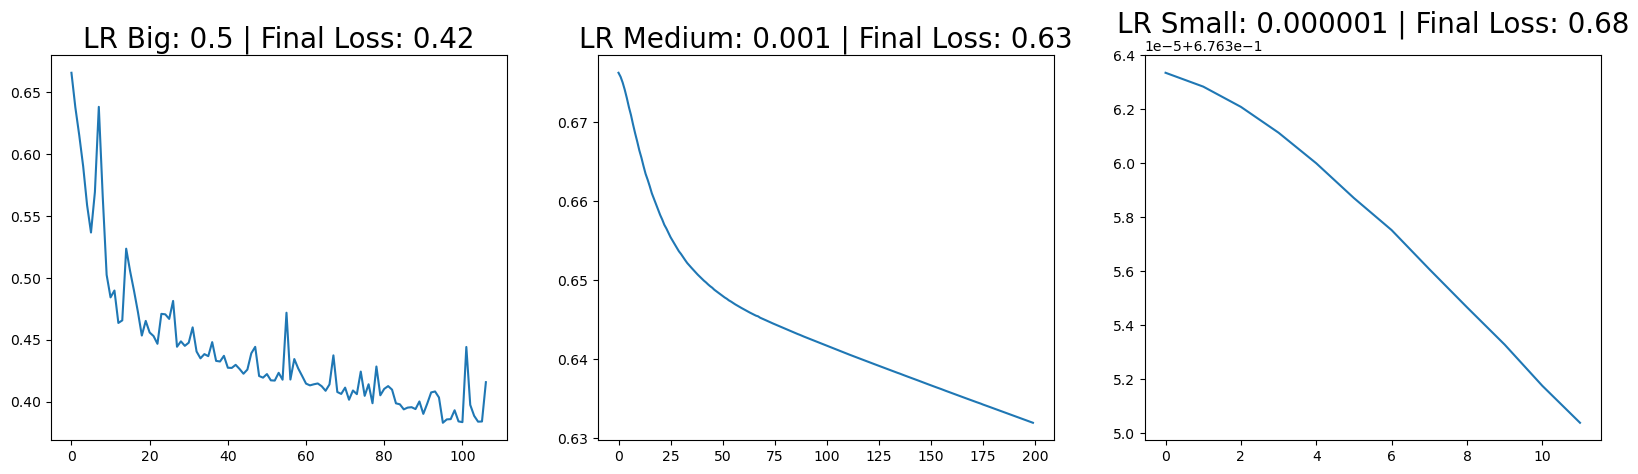

In [40]:
losses_big = model_lr_big.loss_curve_
iterations_big = range(model_lr_big.n_iter_)
losses_medium = model_lr_medium.loss_curve_
iterations_medium = range(model_lr_medium.n_iter_)
losses_small = model_lr_small.loss_curve_
iterations_small = range(model_lr_small.n_iter_)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('LR Big: 0.5 | Final Loss: ' + str(round(model_lr_big.loss_,2)), fontsize=20)
sns.lineplot(x = iterations_big, y = losses_big)
plt.subplot(132)
plt.title('LR Medium: 0.001 | Final Loss: ' + str(round(model_lr_medium.loss_,2)),fontsize=20)
sns.lineplot(x = iterations_medium, y = losses_medium)
plt.subplot(133)
plt.title('LR Small: 0.000001 | Final Loss: ' + str(round(model_lr_small.loss_,2)),fontsize=20)
sns.lineplot(x = iterations_small, y = losses_small)